<a href="https://colab.research.google.com/github/Khalid-Rafiq-01/Image-Segmentation-Pets-Datset/blob/main/Patches_Approach_Pre_processing_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The main purpose of the notebook is:
* Develop a function that creates patches of user defined size, such that there is no need to do **resize** for a very high resolution image.
* **While creating these patches, we pre-process them so as to remove patches that contain sparse information ('sparcity' metric specified by the user).**
* Save all these image into a local drive as in numpy format so that they can be assessed later for training.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import tensorflow_datasets as tfds

In [ ]:
# Let us try to load a fraction of the images from the large pet dataset from drive into the working directory:
img_dir = '/content/drive/MyDrive/Am Prototype 1/Images'
mask_dir = '/content/drive/MyDrive/Am Prototype 1/Masks'

In [ ]:
# Let us read the images first and load them:
images_dir = [] 
images_path = []
for dir, sub_dir, files in os.walk(img_dir):
    files.sort()  # Sort the files in-place
    images_path.append(files)
    #Save the path of these files:
    for i in files:
        img_path = os.path.join(dir, i)
        image_data = cv2.imread(img_path)
        if image_data is None:
          print(f'None type found: {img_path}')
        if image_data is not None:
          image_data = image_data/255
          images_dir.append(image_data)

In [ ]:
# Let us read the masks now and load them:
masks_dir = []
masks_path = [] 
for dir, sub_dir, files in os.walk(mask_dir):
    files.sort()  # Sort the files in-place
    masks_path.append(files)
    #Save the path of these files:
    for i in files:
        mask_path = os.path.join(dir, i)
        mask_data = cv2.imread(mask_path)
        if mask_data is None:
          print(f'None type found: {mask_path}')
        if mask_data is not None:
          mask_data = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
          masks_dir.append(mask_data)

In [ ]:
print(f'The number of images in directory are: {len(images_dir)}')
print(f'The number of masks in directory are: {len(masks_dir)}')

The number of images in directory are: 999
The number of masks in directory are: 999


We are only loading a fractio of the images, around 10% of the total images in the library!

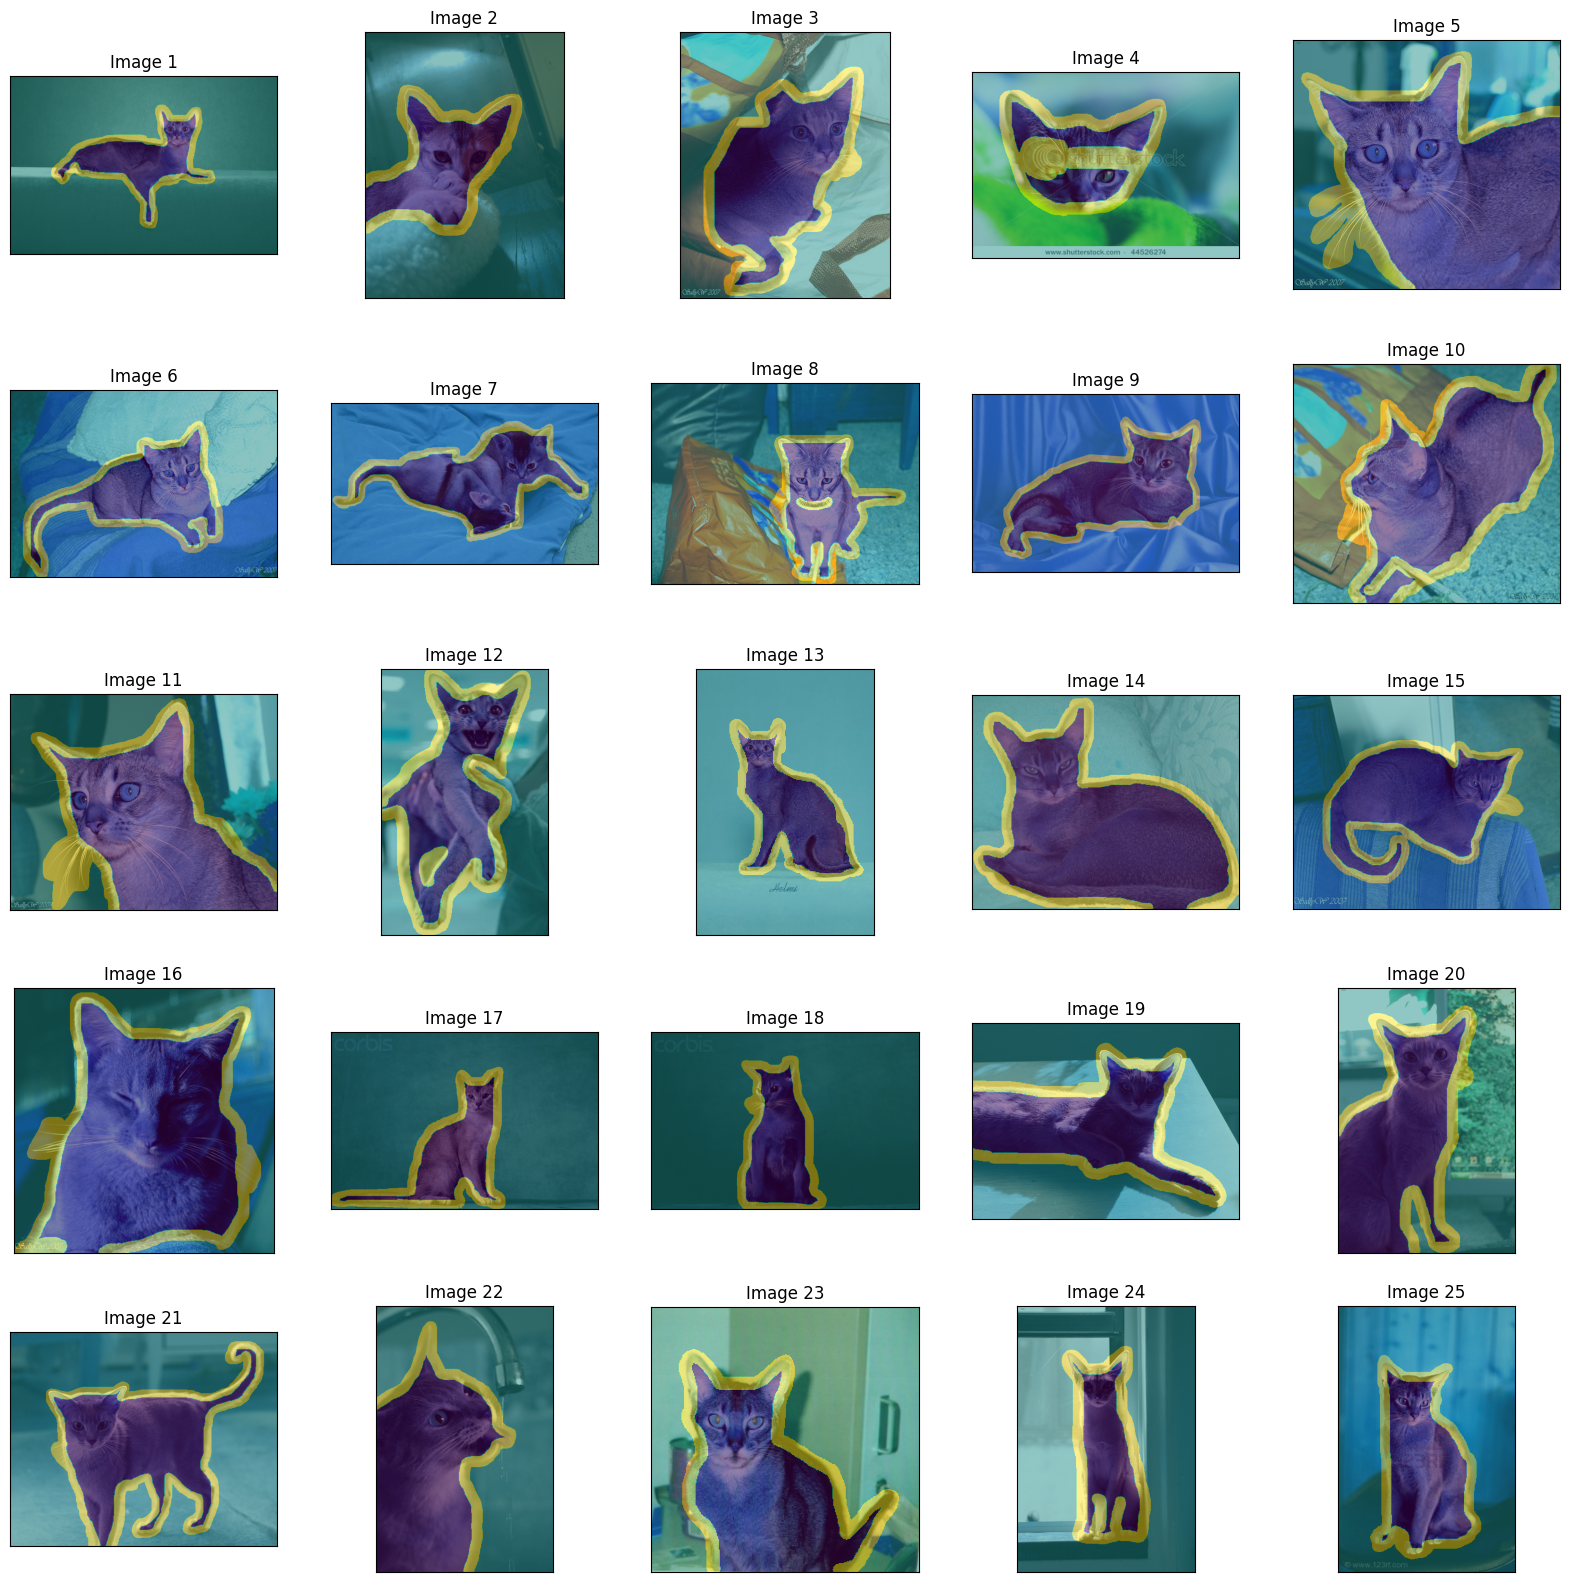

In [ ]:
# Set up the subplots
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(20, 20))
# Loop through the first 25 images and masks
for i in range(25):
    # Get the image and mask
    image = images_dir[i]
    mask = masks_dir[i]   
    # Set up the subplot for this image and mask
    row = i // 5
    col = i % 5
    ax = axes[row, col]
    
    # Plot the image and mask
    ax.imshow(image)
    ax.imshow(mask, alpha=0.5)  # Set alpha to 0.6 to make the mask semi-transparent    
    # Set the title of the subplot
    ax.set_title(f"Image {i+1}")
    
    # Remove the x and y axis ticks and labels
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Show the plot
plt.show()


In [ ]:
# Let us calculate a metric like the mean for the optimal shape images (x_optimal, y_optimal, 3) 
def mean(input_dir, axis):
  data = []
  for i in images_dir:
    data.append(i.shape[axis])
  mu = (sum(data))/len(data)
  print(f'Value of mean along the {axis} axis is:{mu}')
  print(f'Min resolution along the {axis} axis is:{min(data)}')
  print(f'Max resolution along the {axis} axis is:{max(data)}')
  return data, mu

In [ ]:
# Visualizing the distribution of images shape along the Y axis:
data_y, mu_y = mean(images_dir, 0)
# data_y is the resolution along the y-axis
data_x, mu_x = mean(images_dir, 1)

Value of mean along the 0 axis is:389.025025025025
Min resolution along the 0 axis is:116
Max resolution along the 0 axis is:1600
Value of mean along the 1 axis is:435.0
Min resolution along the 1 axis is:119
Max resolution along the 1 axis is:1646


Text(0, 0.5, 'Y-Axis Resolution')

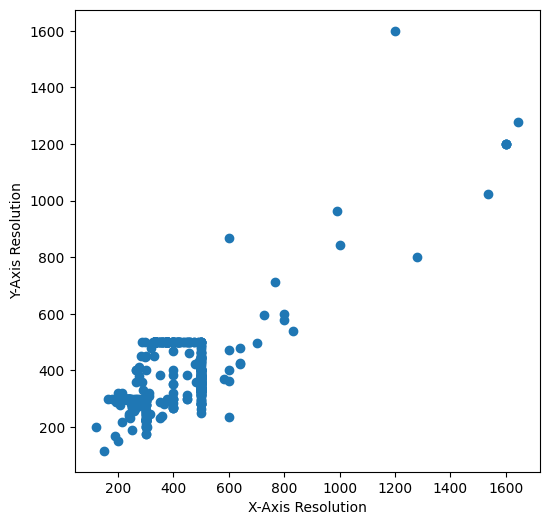

In [ ]:
# Plotting the figure resolution dimensions after removing smaller image resolutions:
plt.figure(figsize = (6,6))
plt.scatter(data_x,data_y)
plt.xlabel('X-Axis Resolution')
plt.ylabel('Y-Axis Resolution')

Let us remove some of the outliers from this image. The major reason is to keep a min resolution that we can pass in as patch size and then create patches from a large image:

In [ ]:
# Let us count the number of Images that have a resolution of less than (256,256,3)
count = 0
print(f'Total number of images is: {len(data_x)}') 
for i in range(len(data_x)):
  if data_x[i]<256 and data_y[i]<256:
    count += 1
print(f'The total number of images with a size less than 256,256 is: {count}')
print(f'The percentage of images with this res: {(count/len(data_x))*100}%')

Total number of images is: 999
The total number of images with a size less than 256,256 is: 9
The percentage of images with this res: 0.9009009009009009%


Most of the images are around (256,600) to (256, 256) to 

**Let us introduce a function, that takes an image and breaks it into patches (Usually used for satellite imaging). One main reason to do this is to be able to deploy the trained model later to work on an image of any input shape. Also, I observed that since the images in this dataset have very varying size (116, 119, 3) to (1600,1646,3), reshaping such an image to (256,256,3) will blur the image by a large margin and that may have an effect on the efficiency of DL model!*

In [ ]:
pip install patchify # Patchify is not present in the library

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from patchify import patchify

In [ ]:
# Function called block_tiles; takes in images and patch size; returns tiles with dim that are multiples of image dim.
def block_tiles(image_or_mask, visualize):
  size_x = (image_or_mask.shape[1]//patch_size)*patch_size # integral multiple of patch_size
  size_y = (image_or_mask.shape[0]//patch_size)*patch_size # integral multiple of patch_size
  # Slicing operation to crop out the image:

  if len(image_or_mask.shape) == 3:
    cropped_image = image_or_mask[0:size_y, 0:size_x,:]
    tile_size = (patch_size, patch_size, 3)
    tiles = patchify(image_or_mask, tile_size, step = tile_size) # creating patches/tiles from the large image:
  else:
    cropped_image = image_or_mask[0:size_y, 0:size_x]
    tile_size = (patch_size, patch_size)
    tiles = patchify(image_or_mask, tile_size, step = tile_size) # creating patches/tiles from the large image:

 # Visualization:
  if visualize == 'on': # Used to visualize the tiles/patches 
      tile_visualize(tiles)
  elif visualize == 'off':
      pass
  return tiles


**Original image is cropped to a multiple of the patch size (Some fraction of input image data is lost). Thus it may be tempting to create small patches but it will generate more images, hence more RAM. Also, I observed for a small patch i.e (100,100), the segmentation task works poorly. One reason may be that each image carries less information in terms of relation of pixels and conveying a story to the DL model**

In [ ]:
# Visualizing the tiles(masks/images):
def tile_visualize(tiles):
  n_y = tiles.shape[0]
  n_x = tiles.shape[1]
  
  fig, axs = plt.subplots(n_y, n_x, figsize=(8, 6))
  if n_y == 1 or n_x == 1:  # Only if one row or one column of images is possible
    axs = axs.reshape(-1)
    for i in range(n_y):
      for j in range(n_x):
        tile_patch = tiles[i, j, 0]
        axs[i * n_x + j].imshow(tile_patch)
        axs[i * n_x + j].axis('off')

  if n_x*n_y > 2:
    for i in range(n_y):
      for j in range(n_x):
        axs[i,j].imshow(tiles[i,j,0])
        axs[i,j].axis('off')

  plt.show()

Original first image having a seolution of: (400, 600, 3)


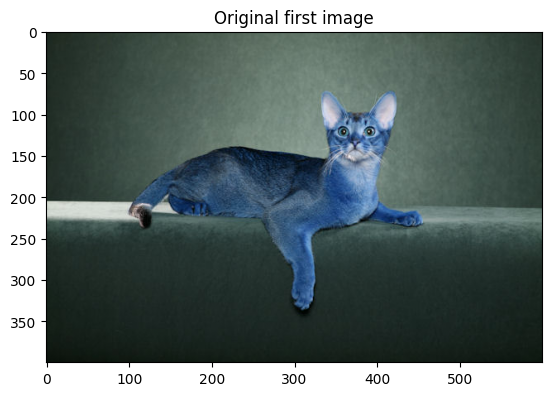

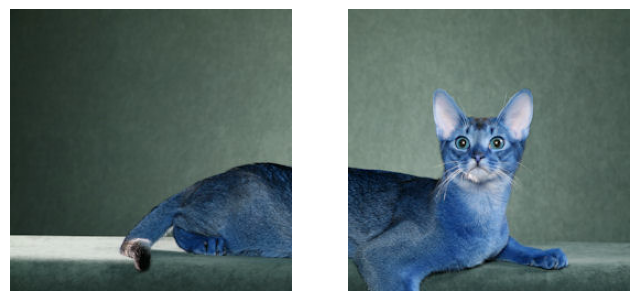

Tiles generated using patch size of (256, 256, 3)


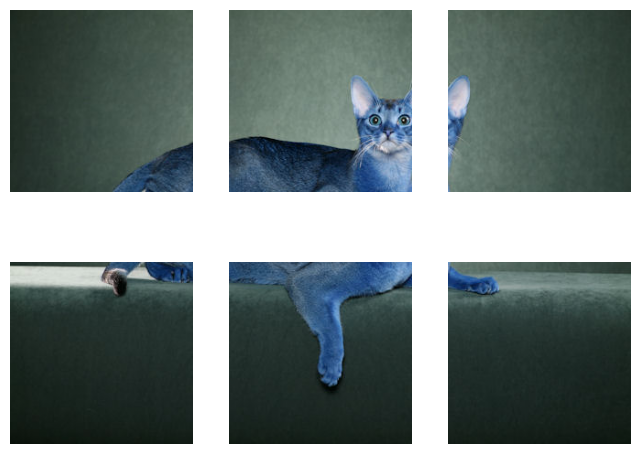

Tiles generated using patch size of (200, 200, 3)


In [ ]:
# Let us visualize what this function does to a single image: Importing the first pet image from the library:
plt.imshow(images_dir[0])
plt.title('Original first image')
print(f'Original first image having a seolution of: {images_dir[0].shape}')

# Let us now split this image using the above defined functions:
patch_size = 256
tiles = block_tiles(images_dir[0], visualize = 'on')
print(f'Tiles generated using patch size of (256, 256, 3)')
# Reducing the patch size:
patch_size = 200
tiles = block_tiles(images_dir[0], visualize = 'on')
print(f'Tiles generated using patch size of (200, 200, 3)')

Let us now define a batch-generator function. It performs these tasks:
1. Reads all the images in the colab.
2. Only stores images within a specified input image shape(removes the outliers). This is important because if patch size > image size --> error.
3. Performs the tiling operation and appends all data in a 4-D array! 

In [ ]:
min_image_dim = 300 # Min dim of images (300, 3000,3): 
max_image_dim = 1000 # Max dim of images (1000, 1000, 3)

In [ ]:
# Define a generator function to read data in batches
def data_generator(img_dir, mask_dir): 
    images_dir = []
    masks_dir = []
    for dir, sub_dir, files in os.walk(img_dir):
        files.sort()
        for i in files:
            img_path = os.path.join(dir, i)
            image_data = cv2.imread(img_path)
            if image_data.shape[0]>=min_image_dim and image_data.shape[1]>=min_image_dim and image_data.shape[0]<=max_image_dim and image_data.shape[1]<=max_image_dim:
                image_data = image_data/255
                image_data = block_tiles(image_data, visualize='off')
                image_data = image_data.reshape(-1,patch_size,patch_size,3)
                images_dir.append(image_data)
        single_list = [item for sublist in images_dir for item in sublist]
        images_array_tiles = np.array(single_list)

    for dir, sub_dir, files in os.walk(mask_dir):
        files.sort()
        for i in files:
            mask_path = os.path.join(dir, i)
            mask_data = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            if mask_data.shape[0]>=min_image_dim and mask_data.shape[1]>=min_image_dim and mask_data.shape[0]<=max_image_dim and mask_data.shape[1]<=max_image_dim:
              mask_data -= 1
              mask_data = block_tiles(mask_data, visualize='off')
              mask_data = mask_data.reshape(-1,patch_size,patch_size,1)
              masks_dir.append(mask_data)
        single_list_1 = [item for sublist in masks_dir for item in sublist]
        masks_array_tiles = np.array(single_list_1)
    return images_array_tiles, masks_array_tiles


In [ ]:
patch_size = 256
images_dir, masks_dir  = data_generator(img_dir, mask_dir)

In [ ]:
print(f'Number of {patch_size,patch_size,3} images in the images_dir are: {len(images_dir)}')
print(f'Number of {patch_size,patch_size,3} masks in the masks_dir are: {len(masks_dir)}')

Number of (256, 256, 3) images in the images_dir are: 866
Number of (256, 256, 3) masks in the masks_dir are: 866


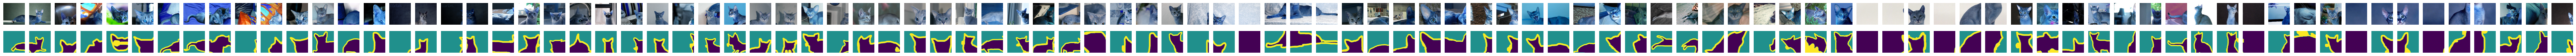

In [ ]:
# Visualizing all the images and the masks in the nootbook:
# Create a 2x100 grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=100, figsize=(100, 2))

# Iterate over the first 100 images and masks
for i in range(100):
    # Plot the image on the left side of the subplot
    axes[0, i].imshow(images_dir[i], extent=(-1, 1, -1, 1))
    axes[0, i].axis('off')
    # Plot the mask on the right side of the subplot
    axes[1, i].imshow(masks_dir[i], extent=(-1, 1, -1, 1))
    axes[1, i].axis('off')

# Show the plot
plt.show()

Observation: The second last image in the above visualization does not contain any feature, and this is frequently the case if the patch size is small. Presently we have a good patch size (256, 256,3). 

Improvement: **We can remove such blank images from the directory based on the pixel values**

*Only three pixel values : 0 = Foreground **------** 1 = Background **------** 2 = Contour*

In [ ]:
# Converting the data in images and masks inro numpy array:
images = np.array(images_dir)
masks = np.array(masks_dir)
print(f'The shape of the images is: {images.shape}')
print(f'The shape of the masks is: {images.shape}')

The shape of the images is: (866, 256, 256, 3)
The shape of the masks is: (866, 256, 256, 3)


In [ ]:
# Let us check the unique values that are present in the masks numpy array:
unique_pixels = np.unique(masks, return_counts=True)
print(f'The unique values in the masks numpy are: {unique_pixels}')

The unique values in the masks numpy are: (array([0, 1, 2], dtype=uint8), array([17626647, 32674949,  6452580]))


**Visualizing the 1st mask and the 15th mask in the above visualization:* 

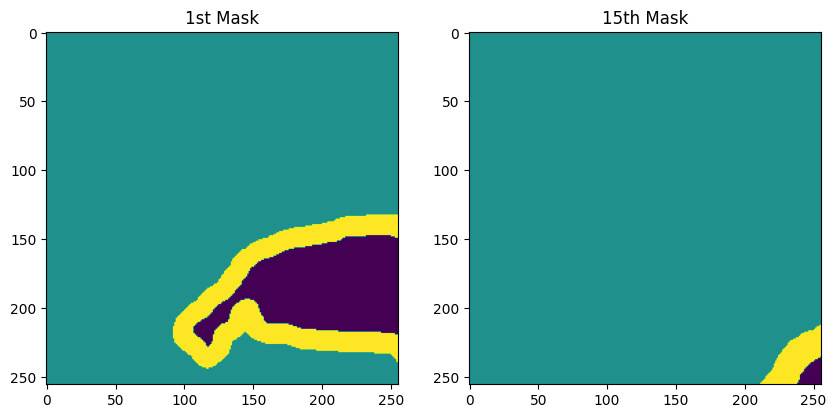

For the 1st mask: (array([0, 1, 2], dtype=uint8), array([ 7032, 52866,  5638]))
For the 15th mask: (array([0, 1, 2], dtype=uint8), array([  236, 64326,   974]))


In [ ]:
import matplotlib.pyplot as plt

# First mask:
masks_0 = masks_dir[0]
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(masks_0)
ax[0].set_title('1st Mask')

# 15th mask:
masks_15 = masks_dir[15]
ax[1].imshow(masks_15)
ax[1].set_title('15th Mask')

plt.show()
print(f'For the 1st mask: {np.unique(masks_0, return_counts = True)}')
print(f'For the 15th mask: {np.unique(masks_15, return_counts = True)}')

In [ ]:
np_1 = 100-(52866/(256*256))*100
np_2 = 100-(64326/(256*256))*100
print(f'No. of non-background pixels in 1st image = {np_1}%')
print(f'No. of non-background pixels in 15th image = {np_2}%')

No. of non-background pixels in 1st image = 19.3328857421875%
No. of non-background pixels in 15th image = 1.8463134765625%


*Observe that we can remove the 15th image since it contins very sparse info. We will keep a threshold of 15%. Only images with background pixels < 15% will be rejected*

In [ ]:
non_sparse_list = []

for i in range(0,len(images_dir)):
  val, counts = np.unique(masks_dir[i], return_counts = True)

  if len(val) == 3:
    fraction = 100*(counts[1]/counts.sum()) # pixel value 1 is background
    if fraction < 85: # is background > 85% of total image --> reject it, else save it!
      non_sparse_list.append(i)

  if len(val) == 2:
    if val[0] == 0 and val[1] == 1:
      fraction = 100*(counts[1]/counts.sum())
      if fraction < 85:
        non_sparse_list.append(i)
    if val[0] == 1 and val[1] == 2:
      fraction = 100*(counts[0]/counts.sum())
      if fraction < 85:
        non_sparse_list.append(i)
    if val[0] == 0 and val[1] == 2: # No background present
      non_sparse_list.append(i)

  if len(val) == 1:
    if val[0] == 1:
      pass
    else:
      non_sparse_list.append(i)


In [ ]:
print(f'Index that contains better info pixels: {non_sparse_list}')
print(f'Number of images with background pixels > 15%  -:- {len(images_dir) - len(non_sparse_list)}')

Index that contains better info pixels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 16, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 69, 70, 71, 74, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 88, 89, 90, 92, 93, 95, 96, 97, 98, 99, 100, 102, 103, 104, 105, 106, 107, 108, 109, 110, 112, 113, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 135, 136, 138, 139, 141, 142, 143, 144, 145, 146, 147, 150, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 164, 165, 166, 167, 168, 169, 170, 171, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 230, 231, 232, 233, 234, 235, 236, 237, 238, 

In [ ]:
# Let us save images from the basic directory into a non sparse directory:
non_spase_images = []
non_spase_masks = []
for i in non_sparse_list:
  non_spase_images.append(images_dir[i])
  non_spase_masks.append(masks_dir[i])
non_spase_images = np.array(non_spase_images)
non_spase_masks = np.array(non_spase_masks)

*Sanity Check*

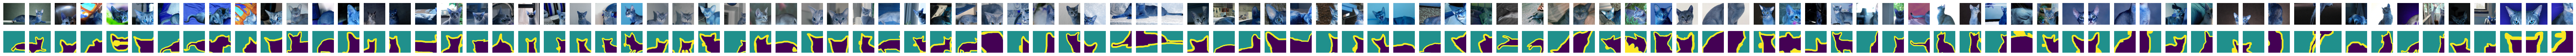

In [ ]:
# Let us again visualize the first 100 images and corrosponding masks:
# Visualizing all the images and the masks in the nootbook:
# Create a 2x100 grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=100, figsize=(100, 2))

# Iterate over the first 100 images and masks
for i in range(100):
    # Plot the image on the left side of the subplot
    axes[0, i].imshow(non_spase_images[i], extent=(-1, 1, -1, 1))
    axes[0, i].axis('off')
    # Plot the mask on the right side of the subplot
    axes[1, i].imshow(non_spase_masks[i], extent=(-1, 1, -1, 1))
    axes[1, i].axis('off')

# Show the plot
plt.show()

*Observe that the 15th image in the image_dir has not been stored in the non_space_images*

In [ ]:
# Let us now break the data in train and validation, with validation same as test: 
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(non_spase_images, non_spase_masks, test_size=0.05, random_state=100)

In [ ]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(731, 256, 256, 3)
(39, 256, 256, 3)
(731, 256, 256, 1)
(39, 256, 256, 1)


*Let us save these pre processed images into the local directory!*

In [ ]:
# Paths where to save the data:
train_images_path = '/content/drive/MyDrive/Processed Oxford IIIT Dataset/Train/Images'
train_masks_path = '/content/drive/MyDrive/Processed Oxford IIIT Dataset/Train/Masks'

val_images_path = '/content/drive/MyDrive/Processed Oxford IIIT Dataset/Val/Images'
val_masks_path = '/content/drive/MyDrive/Processed Oxford IIIT Dataset/Val/Masks'

In [ ]:
print(len(x_train))
print(len(x_test))

731
39


In [ ]:
# Let us try to save these  processed images back into drive: 1862, 99 -----> 2726, 145 ---->3647, 194 ----> 4502, 239 ---> 5307, 282
for i in range(len(x_train)):
  image = x_train[i]
  mask = y_train[i]
  np.save(f'{train_images_path}/image_{i+4502}.npy', image)
  np.save(f'{train_masks_path}/mask_{i+4502}.npy', mask)

for i in range(len(x_test)):
  image = x_test[i]
  mask = y_test[i]
  np.save(f'{val_images_path}/image_{i+239}.npy', image)
  np.save(f'{val_masks_path}/mask_{i+239}.npy', mask)



*Sanity Check*

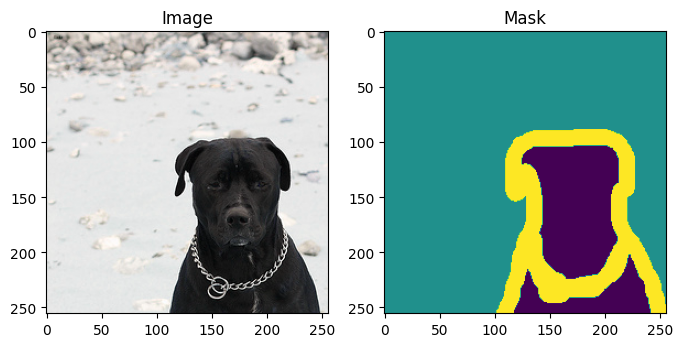

In [ ]:
images_path_train = ('/content/drive/MyDrive/Processed Oxford IIIT Dataset/Train/Images')
masks_path_train = ('/content/drive/MyDrive/Processed Oxford IIIT Dataset/Train/Masks')

# Loading a random image and a corrosping mask:
num = np.random.randint(4502, 4502+len(x_train))
img = np.load(f'{images_path_train}/image_{num}.npy')
mask = np.load(f'{masks_path_train}/mask_{num}.npy')

fig, axs = plt.subplots(1, 2, figsize=(8,8))
axs[0].imshow(img)
axs[0].set_title('Image')

axs[1].imshow(mask)
axs[1].set_title('Mask')

plt.show()

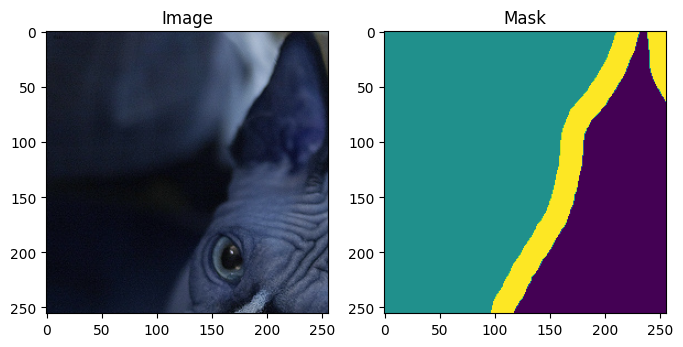

In [ ]:
images_path_val = ('/content/drive/MyDrive/Processed Oxford IIIT Dataset/Val/Images')
masks_path_val = ('/content/drive/MyDrive/Processed Oxford IIIT Dataset/Val/Masks')

# Loading a random image and a corrosping mask:
num = np.random.randint(239, 239+len(x_test))

img = np.load(f'{images_path_val}/image_{num}.npy')
mask = np.load(f'{masks_path_val}/mask_{num}.npy')

fig, axs = plt.subplots(1, 2, figsize=(8,8))
axs[0].imshow(img)
axs[0].set_title('Image')

axs[1].imshow(mask)
axs[1].set_title('Mask')

plt.show()